In [ ]:
!pip install unidecode

In [880]:
!pip install yellowbrick

     |████████████████████████████████| 271 kB 1.4 MB/s            
     |████████████████████████████████| 15.6 MB 956 kB/s            
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.4
    Uninstalling numpy-1.21.4:
      Successfully uninstalled numpy-1.21.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-ml 2021.11.30 requires numpy>=1.20.0, but you have numpy 1.19.5 which is incompatible.


In [1008]:
import requests
from requests import get
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, max_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import time

import re

from tqdm import tqdm_notebook as tqdm

from unidecode import unidecode
import unicodedata

from yellowbrick.regressor import ResidualsPlot, prediction_error, residuals_plot

In [162]:
country_list = ['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Peru', 'Uruguay']


In [178]:
#Website has drop-down menu of cities in each country represented on HostelWorld

soup_argentina_html = '''
<select name="city" id="citySelect" class="needsclick" style="display: inline-block;">
                                    
                                <option value="">Select a city</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/bariloche">Bariloche</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/barreal">Barreal</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/buenos-aires">Buenos Aires</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/cachi">Cachi</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/cafayate">Cafayate</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/concordia">Concordia</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/cordoba">Cordoba</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/el-bolson">El Bolson</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/el-calafate">El Calafate</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/el-chalten">El Chalten</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/esquel">Esquel</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/gualjaina">Gualjaina</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/humahuaca">Humahuaca</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/la-plata">La Plata</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/mar-del-plata">Mar del Plata</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/mendoza">Mendoza</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/mina-clavero">Mina Clavero</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/puerto-iguazu">Puerto Iguazu</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/puerto-madryn">Puerto Madryn</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/purmamarca">Purmamarca</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/rada-tilly">Rada Tilly</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/rosario">Rosario</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/salta">Salta</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/san-ignacio">San Ignacio</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/san-lorenzo">San Lorenzo</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/san-martin-de-los-andes">San Martin De Los Andes</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/san-miguel-de-tucuman">San Miguel de Tucuman</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/san-pedro">San Pedro</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/san-rafael">San Rafael</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/san-salvador-de-jujuy">San Salvador de Jujuy</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/tandil">Tandil</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/tilcara">Tilcara</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/ushuaia">Ushuaia</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/villa-carlos-paz">Villa Carlos Paz</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/villa-gesell">Villa Gesell</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/villa-la-angostura">Villa La Angostura</option><option value="https://www.hostelworld.com/st/hostels/south-america/argentina/villa-pehuenia">Villa Pehuenia</option></select>
'''

soup_bolivia_html = '''
<select name="city" id="citySelect" class="needsclick" style="display: inline-block;">
                                    
                                <option value="">Select a city</option><option value="https://www.hostelworld.com/st/hostels/south-america/bolivia/copacabana">Copacabana</option><option value="https://www.hostelworld.com/st/hostels/south-america/bolivia/la-paz">La Paz</option><option value="https://www.hostelworld.com/st/hostels/south-america/bolivia/rurrenabaque">Rurrenabaque</option><option value="https://www.hostelworld.com/st/hostels/south-america/bolivia/samaipata">Samaipata</option><option value="https://www.hostelworld.com/st/hostels/south-america/bolivia/santa-cruz-de-la-sierra">Santa Cruz de la Sierra</option><option value="https://www.hostelworld.com/st/hostels/south-america/bolivia/sucre">Sucre</option><option value="https://www.hostelworld.com/st/hostels/south-america/bolivia/tupiza">Tupiza</option></select>
'''

soup_brazil_html = '''
<select name="city" id="citySelect" class="needsclick" style="display: inline-block;">
                                    
                                <option value="">Select a city</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/alcantara">Alcantara</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/alter-do-chao">Alter do Chao</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/andarai">Andarai</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/aparecida">Aparecida</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/arraial-d-ajuda">Arraial D'Ajuda</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/arraial-do-cabo">Arraial do Cabo</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/balneario-camboriu">Balneario Camboriu</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/barreirinhas">Barreirinhas</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/belem">Belem</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/belo-horizonte">Belo Horizonte</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/bertioga">Bertioga</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/boa-vista">Boa Vista</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/bombinhas">Bombinhas</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/bonito">Bonito</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/brasilia">Brasilia</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/buzios">Buzios</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/cabo-frio">Cabo Frio</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/cajueiro-da-praia">Cajueiro da Praia</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/cambara-do-sul">Cambara do Sul</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/canoa-quebrada">Canoa Quebrada</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/caraiva">Caraiva</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/caxias-do-sul">Caxias Do Sul</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/corumba">Corumba</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/curitiba">Curitiba</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/embu-das-artes">Embu das Artes</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/fernando-de-noronha">Fernando de Noronha</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/florianopolis">Florianopolis</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/fortaleza">Fortaleza</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/foz-do-iguacu">Foz do Iguacu</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/gramado">Gramado</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/guarda-do-embau">Guarda do Embau</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/guaruja">Guaruja</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/guarulhos">Guarulhos</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/ilha-grande">Ilha Grande</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/ilhabela">Ilhabela</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/imbassai">Imbassai</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/itacare">Itacare</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/itanhaem">Itanhaem</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/jericoacoara">Jericoacoara</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/joao-pessoa">Joao Pessoa</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/lencois">Lencois</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/maceio">Maceio</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/manaus">Manaus</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/maragogi">Maragogi</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/mata-de-sao-joao">Mata de São João</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/morro-de-sao-paulo">Morro de Sao Paulo</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/natal">Natal</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/niteroi">Niteroi</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/ouro-preto">Ouro Preto</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/palmas">Palmas</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/paraty">Paraty</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/parnaiba">Parnaiba</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/penha">Penha</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/pipa">Pipa</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/piracicaba">Piracicaba</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/porto-alegre">Porto Alegre</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/porto-belo">Porto Belo</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/porto-de-galinhas">Porto de Galinhas</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/praia-do-forte">Praia do Forte</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/praia-do-rosa">Praia do Rosa</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/praia-grande">Praia Grande</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/presidente-figuereido">Presidente Figuereido</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/recife">Recife</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/rio-das-ostras">Rio das Ostras</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/rio-de-janeiro">Rio de Janeiro</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/salvador">Salvador</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/santos">Santos</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/sao-bento-do-sul">Sao Bento do Sul</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/sao-joao-del-rei">Sao Joao Del Rei</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/sao-luis">Sao Luis</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/sao-paulo">Sao Paulo</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/sao-sebastiao">Sao Sebastiao</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/saquarema">Saquarema</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/serra-do-cipo">Serra do Cipo</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/tiradentes">Tiradentes</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/torres">Torres</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/trindade">Trindade</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/ubatuba">Ubatuba</option><option value="https://www.hostelworld.com/st/hostels/south-america/brazil/vitoria">Vitoria</option></select>
'''

soup_chile_html = '''
<select name="city" id="citySelect" class="needsclick" style="display: inline-block;">
                                    
                                <option value="">Select a city</option><option value="https://www.hostelworld.com/st/hostels/south-america/chile/arica">Arica</option><option value="https://www.hostelworld.com/st/hostels/south-america/chile/chiloe">Chiloe</option><option value="https://www.hostelworld.com/st/hostels/south-america/chile/coyhaique">Coyhaique</option><option value="https://www.hostelworld.com/st/hostels/south-america/chile/elqui-valley">Elqui Valley</option><option value="https://www.hostelworld.com/st/hostels/south-america/chile/iquique">Iquique</option><option value="https://www.hostelworld.com/st/hostels/south-america/chile/la-serena">La Serena</option><option value="https://www.hostelworld.com/st/hostels/south-america/chile/pichilemu">Pichilemu</option><option value="https://www.hostelworld.com/st/hostels/south-america/chile/pucon">Pucon</option><option value="https://www.hostelworld.com/st/hostels/south-america/chile/puerto-natales">Puerto Natales</option><option value="https://www.hostelworld.com/st/hostels/south-america/chile/puerto-varas">Puerto Varas</option><option value="https://www.hostelworld.com/st/hostels/south-america/chile/punta-arenas">Punta Arenas</option><option value="https://www.hostelworld.com/st/hostels/south-america/chile/san-pedro-de-atacama">San Pedro de Atacama</option><option value="https://www.hostelworld.com/st/hostels/south-america/chile/santiago">Santiago</option><option value="https://www.hostelworld.com/st/hostels/south-america/chile/valdivia">Valdivia</option><option value="https://www.hostelworld.com/st/hostels/south-america/chile/valparaiso">Valparaiso</option><option value="https://www.hostelworld.com/st/hostels/south-america/chile/vicuna">Vicuna</option><option value="https://www.hostelworld.com/st/hostels/south-america/chile/vina-del-mar">Vina del Mar</option></select>
'''

soup_colombia_html = '''
<select name="city" id="citySelect" class="needsclick" style="display: inline-block;">
                                    
                                <option value="">Select a city</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/abejorral">Abejorral</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/arcabuco">Arcabuco</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/armenia">Armenia</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/bahia-solano">Bahia Solano</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/barbosa">Barbosa</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/barichara">Barichara</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/barranquilla">Barranquilla</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/baru-island">Baru Island</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/bogota">Bogota</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/bucaramanga">Bucaramanga</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/buenaventura">Buenaventura</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/cali">Cali</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/capurgana">Capurgana</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/cartagena">Cartagena</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/choachi">Choachi</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/cienaga">Cienaga</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/el-penol">El Penol</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/filandia">Filandia</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/galerazamba">Galerazamba</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/guachaca">Guachaca</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/guadalupe">Guadalupe</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/guaduas">Guaduas</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/guamal">Guamal</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/guatape">Guatape</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/isla-fuerte">Isla Fuerte</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/isla-palma">Isla Palma</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/jardin">Jardin</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/jerico">Jerico</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/la-mesa">La Mesa</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/leticia">Leticia</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/manizales">Manizales</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/medellin">Medellin</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/minca">Minca</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/mocoa">Mocoa</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/mompos">Mompos</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/mongui">Mongui</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/neiva">Neiva</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/nuqui">Nuqui</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/palomino">Palomino</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/pasto">Pasto</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/pereira">Pereira</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/popayan">Popayan</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/pueblo-bello">Pueblo Bello</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/puerto-colombia">Puerto Colombia</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/puerto-narino">Puerto Narino</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/rincon-del-mar">Rincon del Mar</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/riohacha">Riohacha</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/rosario-island">Rosario Island</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/salento">Salento</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/salgar">Salgar</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/san-agustin">San Agustin</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/san-andres-island">San Andres Island</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/san-gil">San Gil</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/san-rafael">San Rafael</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/santa-fe-de-antioquia">Santa Fe de Antioquia</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/santa-marta">Santa Marta</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/santa-rosa-de-cabal">Santa Rosa de Cabal</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/sapzurro">Sapzurro</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/sogamoso">Sogamoso</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/taganga">Taganga</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/tintipan-island">Tintipan Island</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/villa-de-leyva">Villa de Leyva</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/villavicencio">Villavicencio</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/villavieja">Villavieja</option><option value="https://www.hostelworld.com/st/hostels/south-america/colombia/zipaquira">Zipaquira</option></select>
'''

soup_ecuador_html = '''
<select name="city" id="citySelect" class="needsclick" style="display: inline-block;">
                                    
                                <option value="">Select a city</option><option value="https://www.hostelworld.com/st/hostels/south-america/ecuador/alausi">Alausi</option><option value="https://www.hostelworld.com/st/hostels/south-america/ecuador/atacames">Atacames</option><option value="https://www.hostelworld.com/st/hostels/south-america/ecuador/banos">Banos</option><option value="https://www.hostelworld.com/st/hostels/south-america/ecuador/banos-de-agua-santa">Banos de Agua Santa</option><option value="https://www.hostelworld.com/st/hostels/south-america/ecuador/canoa">Canoa</option><option value="https://www.hostelworld.com/st/hostels/south-america/ecuador/chugchilan">Chugchilan</option><option value="https://www.hostelworld.com/st/hostels/south-america/ecuador/cuenca">Cuenca</option><option value="https://www.hostelworld.com/st/hostels/south-america/ecuador/guayaquil">Guayaquil</option><option value="https://www.hostelworld.com/st/hostels/south-america/ecuador/ibarra">Ibarra</option><option value="https://www.hostelworld.com/st/hostels/south-america/ecuador/las-tunas">Las Tunas</option><option value="https://www.hostelworld.com/st/hostels/south-america/ecuador/latacunga">Latacunga</option><option value="https://www.hostelworld.com/st/hostels/south-america/ecuador/machachi">Machachi</option><option value="https://www.hostelworld.com/st/hostels/south-america/ecuador/manglaralto">Manglaralto</option><option value="https://www.hostelworld.com/st/hostels/south-america/ecuador/mindo">Mindo</option><option value="https://www.hostelworld.com/st/hostels/south-america/ecuador/misahualli">Misahualli</option><option value="https://www.hostelworld.com/st/hostels/south-america/ecuador/mompiche">Mompiche</option><option value="https://www.hostelworld.com/st/hostels/south-america/ecuador/montanita">Montanita</option><option value="https://www.hostelworld.com/st/hostels/south-america/ecuador/olon">Olon</option><option value="https://www.hostelworld.com/st/hostels/south-america/ecuador/otavalo">Otavalo</option><option value="https://www.hostelworld.com/st/hostels/south-america/ecuador/puerto-lopez">Puerto Lopez</option><option value="https://www.hostelworld.com/st/hostels/south-america/ecuador/quito">Quito</option><option value="https://www.hostelworld.com/st/hostels/south-america/ecuador/riobamba">Riobamba</option><option value="https://www.hostelworld.com/st/hostels/south-america/ecuador/salinas">Salinas</option><option value="https://www.hostelworld.com/st/hostels/south-america/ecuador/santa-marianita">Santa Marianita</option><option value="https://www.hostelworld.com/st/hostels/south-america/ecuador/tababela">Tababela</option><option value="https://www.hostelworld.com/st/hostels/south-america/ecuador/tena">Tena</option><option value="https://www.hostelworld.com/st/hostels/south-america/ecuador/tonsupa">Tonsupa</option></select>
'''

soup_peru_html = '''
<select name="city" id="citySelect" class="needsclick" style="display: inline-block;">
                                    
                                <option value="">Select a city</option><option value="https://www.hostelworld.com/st/hostels/south-america/peru/aguas-calientes">Aguas Calientes</option><option value="https://www.hostelworld.com/st/hostels/south-america/peru/arequipa">Arequipa</option><option value="https://www.hostelworld.com/st/hostels/south-america/peru/carhuaz">Carhuaz</option><option value="https://www.hostelworld.com/st/hostels/south-america/peru/chachapoyas">Chachapoyas</option><option value="https://www.hostelworld.com/st/hostels/south-america/peru/cusco">Cusco</option><option value="https://www.hostelworld.com/st/hostels/south-america/peru/huacachina">Huacachina</option><option value="https://www.hostelworld.com/st/hostels/south-america/peru/huanchaco">Huanchaco</option><option value="https://www.hostelworld.com/st/hostels/south-america/peru/huaraz">Huaraz</option><option value="https://www.hostelworld.com/st/hostels/south-america/peru/ica">Ica</option><option value="https://www.hostelworld.com/st/hostels/south-america/peru/iquitos">Iquitos</option><option value="https://www.hostelworld.com/st/hostels/south-america/peru/lima">Lima</option><option value="https://www.hostelworld.com/st/hostels/south-america/peru/lobitos">Lobitos</option><option value="https://www.hostelworld.com/st/hostels/south-america/peru/machu-picchu">Machu Picchu</option><option value="https://www.hostelworld.com/st/hostels/south-america/peru/mancora">Mancora</option><option value="https://www.hostelworld.com/st/hostels/south-america/peru/nazca">Nazca</option><option value="https://www.hostelworld.com/st/hostels/south-america/peru/ollantaytambo">Ollantaytambo</option><option value="https://www.hostelworld.com/st/hostels/south-america/peru/paracas">Paracas</option><option value="https://www.hostelworld.com/st/hostels/south-america/peru/pisac">Pisac</option><option value="https://www.hostelworld.com/st/hostels/south-america/peru/puerto-malabrigo-chicama">Puerto Malabrigo Chicama</option><option value="https://www.hostelworld.com/st/hostels/south-america/peru/puerto-maldonado">Puerto Maldonado</option><option value="https://www.hostelworld.com/st/hostels/south-america/peru/puno">Puno</option><option value="https://www.hostelworld.com/st/hostels/south-america/peru/tarapoto">Tarapoto</option><option value="https://www.hostelworld.com/st/hostels/south-america/peru/trujillo">Trujillo</option><option value="https://www.hostelworld.com/st/hostels/south-america/peru/urubamba">Urubamba</option></select>
'''

soup_uruguay_html = '''
<select name="city" id="citySelect" class="needsclick" style="display: inline-block;">
                                    
                                <option value="">Select a city</option><option value="https://www.hostelworld.com/st/hostels/south-america/uruguay/atlantida">Atlantida</option><option value="https://www.hostelworld.com/st/hostels/south-america/uruguay/barra-de-valizas">Barra de Valizas</option><option value="https://www.hostelworld.com/st/hostels/south-america/uruguay/cabo-polonio">Cabo Polonio</option><option value="https://www.hostelworld.com/st/hostels/south-america/uruguay/carmelo">Carmelo</option><option value="https://www.hostelworld.com/st/hostels/south-america/uruguay/colonia-del-sacramento">Colonia del Sacramento</option><option value="https://www.hostelworld.com/st/hostels/south-america/uruguay/la-paloma">La Paloma</option><option value="https://www.hostelworld.com/st/hostels/south-america/uruguay/la-pedrera">La Pedrera</option><option value="https://www.hostelworld.com/st/hostels/south-america/uruguay/montevideo">Montevideo</option><option value="https://www.hostelworld.com/st/hostels/south-america/uruguay/piriapolis">Piriapolis</option><option value="https://www.hostelworld.com/st/hostels/south-america/uruguay/punta-del-diablo">Punta del Diablo</option><option value="https://www.hostelworld.com/st/hostels/south-america/uruguay/punta-del-este">Punta del Este</option></select>
'''


In [180]:
def get_cities(country):
    countries = {
        "argentina": BeautifulSoup(soup_argentina_html, "lxml"),
        "brazil": BeautifulSoup(soup_brazil_html, "lxml"),
        "bolivia": BeautifulSoup(soup_bol_html, "lxml"),
        "chile": BeautifulSoup(soup_chile_html, "lxml"),
        "colombia": BeautifulSoup(soup_col_html, "lxml"),
        "ecuador": BeautifulSoup(soup_ecuador_html, "lxml"),
        "peru": BeautifulSoup(soup_peru_html, "lxml"),
        "uruguay": BeautifulSoup(soup_uruguay_html, "lxml"),
    }
    
    country_str = str(countries[country.lower()].prettify())
    pattern = "\n    (.*?)\n"
    cities = re.findall(pattern, country_str)[1:]

    return cities

In [682]:
cities = []
countries = []
for country in country_list:
    cities.extend(get_cities(country))
    countries.extend(country for i in range(len(get_cities(country))))

cities = [city.replace('ã','a') for city in cities]
print(cities)

['Bariloche', 'Barreal', 'Buenos Aires', 'Cachi', 'Cafayate', 'Concordia', 'Cordoba', 'El Bolson', 'El Calafate', 'El Chalten', 'Esquel', 'Gualjaina', 'Humahuaca', 'La Plata', 'Mar del Plata', 'Mendoza', 'Mina Clavero', 'Puerto Iguazu', 'Puerto Madryn', 'Purmamarca', 'Rada Tilly', 'Rosario', 'Salta', 'San Ignacio', 'San Lorenzo', 'San Martin De Los Andes', 'San Miguel de Tucuman', 'San Pedro', 'San Rafael', 'San Salvador de Jujuy', 'Tandil', 'Tilcara', 'Ushuaia', 'Villa Carlos Paz', 'Villa Gesell', 'Villa La Angostura', 'Villa Pehuenia', 'Copacabana', 'La Paz', 'Rurrenabaque', 'Samaipata', 'Santa Cruz de la Sierra', 'Sucre', 'Tupiza', 'Alcantara', 'Alter do Chao', 'Andarai', 'Aparecida', "Arraial D'Ajuda", 'Arraial do Cabo', 'Balneario Camboriu', 'Barreirinhas', 'Belem', 'Belo Horizonte', 'Bertioga', 'Boa Vista', 'Bombinhas', 'Bonito', 'Brasilia', 'Buzios', 'Cabo Frio', 'Cajueiro da Praia', 'Cambara do Sul', 'Canoa Quebrada', 'Caraiva', 'Caxias Do Sul', 'Corumba', 'Curitiba', 'Embu das

In [328]:
url_base = 'https://www.hostelworld.com/st/hostels/'
cities_url = [city.replace(' ', '-') for city in cities]

#create empty list for each column in data frame
country = []
location = []
name = []
link = []
distance = []
ratings = []
reviews = []
price = []

In [330]:
#tqdm shows a progress bar while the loop is running to determine where an error occurs
for city in tqdm(cities_url):
    print(f"Scraping {city}...")
    url = url_base + str(city)
    response = get(url)
    soup_arg = BeautifulSoup(response.text, 'html.parser')
    hostel_info = soup_arg.find_all(class_= 'fabresult rounded clearfix hwta-property')
    
    for item in hostel_info:
        attribute = item.attrs
        name.append(attribute['data-name'])
        link.append(attribute['url'])
        try: location.append(city)
        except:
            location.append('')
        distance.append(item.find(class_= "addressline").text[12:18].replace('k','').replace('m','').strip())
        ratings.append(item.find(class_='hwta-rating-score').text.replace('\n', '').strip())
        reviews.append(item.find(class_="hwta-rating-counter").text.replace('\n', '').strip())
        price.append(item.find(class_= "price").text.replace('\n', '').strip()[3:])
    time.sleep(1)

/var/folders/k2/jnby64_574b3xrhctstlh30w0000gp/T/ipykernel_19868/1262118445.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for city in tqdm(cities_url):


  0%|          | 0/267 [00:00<?, ?it/s]

Scraping Bariloche...
Scraping Barreal...
Scraping Buenos-Aires...
Scraping Cachi...
Scraping Cafayate...
Scraping Concordia...
Scraping Cordoba...
Scraping El-Bolson...
Scraping El-Calafate...
Scraping El-Chalten...
Scraping Esquel...
Scraping Gualjaina...
Scraping Humahuaca...
Scraping La-Plata...
Scraping Mar-del-Plata...
Scraping Mendoza...
Scraping Mina-Clavero...
Scraping Puerto-Iguazu...
Scraping Puerto-Madryn...
Scraping Purmamarca...
Scraping Rada-Tilly...
Scraping Rosario...
Scraping Salta...
Scraping San-Ignacio...
Scraping San-Lorenzo...
Scraping San-Martin-De-Los-Andes...
Scraping San-Miguel-de-Tucuman...
Scraping San-Pedro...
Scraping San-Rafael...
Scraping San-Salvador-de-Jujuy...
Scraping Tandil...
Scraping Tilcara...
Scraping Ushuaia...
Scraping Villa-Carlos-Paz...
Scraping Villa-Gesell...
Scraping Villa-La-Angostura...
Scraping Villa-Pehuenia...
Scraping Copacabana...
Scraping La-Paz...
Scraping Rurrenabaque...
Scraping Samaipata...
Scraping Santa-Cruz-de-la-Sierra...

In [349]:
#check that number of rows match
print(len(location), len(name), len(price))

1199 1199 1199


In [1070]:
df = pd.read_csv('hostels.csv')

In [1071]:
df = df.drop(['Unnamed: 0'], axis=1)

In [424]:
country = []
def countries(city):
    if city in argentina_cities:
        country.append

argentina_cities = ['Bariloche', 'Barreal', 'Buenos Aires', 'Cachi', 'Cafayate', 'Concordia', 'Cordoba', 'El Bolson', 'El Calafate', 'El Chalten', 'Esquel', 'Gualjaina', 'Humahuaca', 'La Plata', 'Mar del Plata', 'Mendoza', 'Mina Clavero', 'Puerto Iguazu', 'Puerto Madryn', 'Purmamarca', 'Rada Tilly', 'Rosario', 'Salta', 'San Ignacio', 'San Lorenzo', 'San Martin De Los Andes', 'San Miguel de Tucuman', 'San Pedro', 'San Rafael', 'San Salvador de Jujuy', 'Tandil', 'Tilcara', 'Ushuaia', 'Villa Carlos Paz', 'Villa Gesell', 'Villa La Angostura', 'Villa Pehuenia']
bolivia_cities = ['Copacabana', 'La Paz', 'Rurrenabaque', 'Samaipata', 'Santa Cruz de la Sierra', 'Sucre', 'Tupiza']
brazil_cities = ['Alcantara', 'Alter do Chao', 'Andarai', 'Aparecida', "Arraial D'Ajuda", 'Arraial do Cabo', 'Balneario Camboriu', 'Barreirinhas', 'Belem', 'Belo Horizonte', 'Bertioga', 'Boa Vista', 'Bombinhas', 'Bonito', 'Brasilia', 'Buzios', 'Cabo Frio', 'Cajueiro da Praia', 'Cambara do Sul', 'Canoa Quebrada', 'Caraiva', 'Caxias Do Sul', 'Corumba', 'Curitiba', 'Embu das Artes', 'Fernando de Noronha', 'Florianopolis', 'Fortaleza', 'Foz do Iguacu', 'Gramado', 'Guarda do Embau', 'Guaruja', 'Guarulhos', 'Ilha Grande', 'Ilhabela', 'Imbassai', 'Itacare', 'Itanhaem', 'Jericoacoara', 'Joao Pessoa', 'Lencois', 'Maceio', 'Manaus', 'Maragogi', 'Mata de Sao Joao', 'Morro de Sao Paulo', 'Natal', 'Niteroi', 'Ouro Preto', 'Palmas', 'Paraty', 'Parnaiba', 'Penha', 'Pipa', 'Piracicaba', 'Porto Alegre', 'Porto Belo', 'Porto de Galinhas', 'Praia do Forte', 'Praia do Rosa', 'Praia Grande', 'Presidente Figuereido', 'Recife', 'Rio das Ostras', 'Rio de Janeiro', 'Salvador', 'Santos', 'Sao Bento do Sul', 'Sao Joao Del Rei', 'Sao Luis', 'Sao Paulo', 'Sao Sebastiao', 'Saquarema', 'Serra do Cipo', 'Tiradentes', 'Torres', 'Trindade', 'Ubatuba', 'Vitoria', 'Vina del Mar']
colombia_cities = ['Abejorral', 'Arcabuco', 'Armenia', 'Bahia Solano', 'Barbosa', 'Barichara', 'Barranquilla', 'Baru Island', 'Bogota', 'Bucaramanga', 'Buenaventura', 'Cali', 'Capurgana', 'Cartagena', 'Choachi', 'Cienaga', 'El Penol', 'Filandia', 'Galerazamba', 'Guachaca', 'Guadalupe', 'Guaduas', 'Guamal', 'Guatape', 'Isla Fuerte', 'Isla Palma', 'Jardin', 'Jerico', 'La Mesa', 'Leticia', 'Manizales', 'Medellin', 'Minca', 'Mocoa', 'Mompos', 'Mongui', 'Neiva', 'Nuqui', 'Palomino', 'Pasto', 'Pereira', 'Popayan', 'Pueblo Bello', 'Puerto Colombia', 'Puerto Narino', 'Rincon del Mar', 'Riohacha', 'Rosario Island', 'Salento', 'Salgar', 'San Agustin', 'San Andres Island', 'San Gil', 'San Rafael', 'Santa Fe de Antioquia', 'Santa Marta', 'Santa Rosa de Cabal', 'Sapzurro', 'Sogamoso', 'Taganga', 'Tintipan Island', 'Villa de Leyva', 'Villavicencio', 'Villavieja', 'Zipaquira']
ecuador_cities = ['Alausi', 'Atacames', 'Banos', 'Banos de Agua Santa', 'Canoa', 'Chugchilan', 'Cuenca', 'Guayaquil', 'Ibarra', 'Las Tunas', 'Latacunga', 'Machachi', 'Manglaralto', 'Mindo', 'Misahualli', 'Mompiche', 'Montanita', 'Olon', 'Otavalo', 'Puerto Lopez', 'Quito', 'Riobamba', 'Salinas', 'Santa Marianita', 'Tababela', 'Tena', 'Tonsupa']
peru_cities = ['Aguas Calientes', 'Arequipa', 'Carhuaz', 'Chachapoyas', 'Cusco', 'Huacachina', 'Huanchaco', 'Huaraz', 'Ica', 'Iquitos', 'Lima', 'Lobitos', 'Machu Picchu', 'Mancora', 'Nazca', 'Ollantaytambo', 'Paracas', 'Pisac', 'Puerto Malabrigo Chicama', 'Puerto Maldonado', 'Puno', 'Tarapoto', 'Trujillo', 'Urubamba']
uruguay_cities = ['Atlantida', 'Barra de Valizas', 'Cabo Polonio', 'Carmelo', 'Colonia del Sacramento', 'La Paloma', 'La Pedrera', 'Montevideo', 'Piriapolis', 'Punta del Diablo', 'Punta del Este']


In [1072]:
# make df of all cities in South America with population > 500,000
url_wikipedia = 'https://en.wikipedia.org/wiki/List_of_cities_in_South_America#Largest_cities'
response = get(url_wikipedia)

# create soup
soup = BeautifulSoup(response.text, 'html.parser')

table = soup.find('table',{'class':"wikitable"})

df_wikipedia = pd.DataFrame(pd.read_html(str(table))[0])
df_wikipedia = df_wikipedia[['Name', 'Country', 'Population']]


In [1073]:
df_wikipedia = df_wikipedia.rename(columns={'Name':'city'})

In [1074]:
df_wikipedia['city'] = (df_wikipedia['city'].str.normalize('NFKD')
       .str.encode('latin-1', errors='ignore'))
df_wikipedia.city

0                b'Sao Paulo'
1                     b'Lima'
2                   b'Bogota'
3           b'Rio de Janeiro'
4                 b'Santiago'
               ...           
75    b'Aparecida de Goiania'
76             b'Bucaramanga'
77              b'Ananindeua'
78                  b'Soacha'
79             b'Porto Velho'
Name: city, Length: 80, dtype: object

In [1075]:
wiki_list = df_wikipedia.city.tolist()

In [1076]:
df_wikipedia.to_csv('cities.csv')

In [1077]:
df_sa = pd.read_csv('cities.csv', encoding = 'latin-1')

In [1078]:
df_sa

,Unnamed: 0,city,Country,Population
0,0,b'Sao Paulo',Brazil,"12,038,175[1]"
1,1,b'Lima',Peru,"8,894,412[a][2]"
2,2,b'Bogota',Colombia,"7,862,277[b][4]"
3,3,b'Rio de Janeiro',Brazil,"6,476,631[1]"
4,4,b'Santiago',Chile,"5,507,282[c][5]"
...,...,...,...,...
75,75,b'Aparecida de Goiania',Brazil,"521,910[1]"
76,76,b'Bucaramanga',Colombia,"521,446[b][4]"
77,77,b'Ananindeua',Brazil,"505,404[1]"
78,78,b'Soacha',Colombia,"505,319[b][4]"


In [1079]:
wiki_list = df_sa.city.tolist()
wiki_list = [name.strip('b') for name in wiki_list]

In [1080]:
wiki_list = [name.strip("'") for name in wiki_list]

In [1081]:
wiki_list = [name.replace(' ','-') for name in wiki_list]

In [1082]:
df_wikipedia['pop_over_500k'] = 1

In [1083]:
df_wikipedia['city'] = wiki_list

In [1084]:
df_wikipedia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   city           80 non-null     object
 1   Country        80 non-null     object
 2   Population     80 non-null     object
 3   pop_over_500k  80 non-null     int64 
dtypes: int64(1), object(3)
memory usage: 2.6+ KB


In [1085]:
df = pd.merge(df, df_wikipedia[['city','pop_over_500k']], how='left', on= 'city')

In [1086]:
cities = [city.replace(' ','-') for city in cities]
df_countries = pd.DataFrame({'country': countries, 'city': cities})
df_countries

,country,city
0,Argentina,Bariloche
1,Argentina,Barreal
2,Argentina,Buenos-Aires
3,Argentina,Cachi
4,Argentina,Cafayate
...,...,...
262,Uruguay,La-Pedrera
263,Uruguay,Montevideo
264,Uruguay,Piriapolis
265,Uruguay,Punta-del-Diablo


In [1149]:
hostels_3 = pd.merge(df, df_countries, how='left', on='city')
hostels_3.to_csv('hostels_3.csv')


In [1142]:
df = hostels_3
df = df.fillna(0)
df = df.loc[:,~df.columns.duplicated()]
df = df.drop('country_x', axis=1)

In [1146]:
df = df.drop('country', axis=1)

In [1147]:
df

,hostel_name,city,distance_center_km,average_rating,number_reviews,price_usd,pop_over_500k,Argentina,Bolivia,Brazil,Chile,Colombia,Ecuador,Peru
0,Selina Bariloche,Bariloche,0.9,8.3,94,15.00,0.0,1,0,0,0,0,0,0
1,Tangoinn Hostel Downtown,Bariloche,0.7,9.0,791,31.57,0.0,1,0,0,0,0,0,0
2,Berkana Hostel y Bar De Playa,Bariloche,0.6,8.4,108,33.49,0.0,1,0,0,0,0,0,0
3,Hostel Nix,Bariloche,1.4,8.2,16,12.46,0.0,1,0,0,0,0,0,0
4,Patagonia Jazz Hostel 2,Bariloche,0.6,7.0,7,38.48,0.0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014,La Quinta Hostel & Bar,Punta-del-Este,9.9,0.0,0,18.00,0.0,0,0,0,0,0,0,0
1015,Hostel 32,Punta-del-Este,2.6,8.9,105,17.50,0.0,0,0,0,0,0,0,0
1016,Selina Punta del Este,Punta-del-Este,0.2,0.0,0,18.40,0.0,0,0,0,0,0,0,0
1017,Candy Hostel,Punta-del-Este,10.5,0.0,3,25.00,0.0,0,0,0,0,0,0,0


In [1148]:
#data cleaning

#remove letters from distance values
#df.distance_center_km = df.distance_center_km.str.strip(' fr')
df.distance_center_km.astype('float')

#remove hostels with unreasonably low and high prices
df = df[df.price_usd.astype('float') > 3]
df = df[df.price_usd.astype('float') < 100.00]

#remove hostels with 0 reviews and rating
df = df.sort_values(['average_rating','number_reviews'])[100:]

#convert numerical columns to numerical format
list_to_convert = ['distance_center_km', 'average_rating', 'number_reviews', 'price_usd']

for column in list_to_convert:
  df[column] = pd.to_numeric(df[column], errors= 'coerce')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 919 entries, 968 to 416
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   hostel_name         919 non-null    object 
 1   city                919 non-null    object 
 2   distance_center_km  919 non-null    float64
 3   average_rating      919 non-null    float64
 4   number_reviews      919 non-null    int64  
 5   price_usd           919 non-null    float64
 6   pop_over_500k       919 non-null    float64
 7   Argentina           919 non-null    uint8  
 8   Bolivia             919 non-null    uint8  
 9   Brazil              919 non-null    uint8  
 10  Chile               919 non-null    uint8  
 11  Colombia            919 non-null    uint8  
 12  Ecuador             919 non-null    uint8  
 13  Peru                919 non-null    uint8  
dtypes: float64(4), int64(1), object(2), uint8(7)
memory usage: 63.7+ KB


In [1110]:
#create dummy variables to represent country as numeric
dummy = pd.get_dummies(df['country'])
dummy
df = pd.concat([df,dummy], axis=1)
df = df.sort_index()
df = df.drop('Uruguay',axis=1)

In [1126]:
df.sort_values("pop_over_500k", ascending=False)

,hostel_name,city,distance_center_km,average_rating,number_reviews,price_usd,pop_over_500k,country_x,Argentina,Bolivia,...,Peru,Argentina,Bolivia,Brazil,Chile,Colombia,Ecuador,Peru,country_y,country
308,Gaia Hostel,Rio-de-Janeiro,7.7,7.6,134,8.22,1.0,Brazil,0,0,...,0,0,0,1,0,0,0,0,Brazil,Brazil
314,Maracanã Hostel Vila Isabel,Rio-de-Janeiro,1.8,8.4,9,6.39,1.0,Brazil,0,0,...,0,0,0,1,0,0,0,0,Brazil,Brazil
288,Selina Copacabana,Rio-de-Janeiro,10.0,8.9,68,16.00,1.0,Brazil,0,0,...,0,0,0,1,0,0,0,0,Brazil,Brazil
287,Ipanema Beach Hostel,Rio-de-Janeiro,9.6,8.7,518,8.95,1.0,Brazil,0,0,...,0,0,0,1,0,0,0,0,Brazil,Brazil
286,Selina Lapa Rio de Janeiro,Rio-de-Janeiro,5.8,9.0,228,9.94,1.0,Brazil,0,0,...,0,0,0,1,0,0,0,0,Brazil,Brazil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,Rural - La Florida,San-Pedro-de-Atacama,0.1,9.0,631,8.95,0.0,Chile,0,0,...,0,0,0,0,1,0,0,0,Chile,Chile
398,Aji Verde Hostel San Pedro de Atacama,San-Pedro-de-Atacama,0.9,9.7,786,10.57,0.0,Chile,0,0,...,0,0,0,0,1,0,0,0,Chile,Chile
399,Hostal Chiloe,San-Pedro-de-Atacama,0.2,9.4,7,14.92,0.0,Chile,0,0,...,0,0,0,0,1,0,0,0,Chile,Chile
400,Sol Atacama Hostel,San-Pedro-de-Atacama,0.7,9.7,1047,8.44,0.0,Chile,0,0,...,0,0,0,0,1,0,0,0,Chile,Chile


In [1150]:
df.corr()

,distance_center_km,average_rating,number_reviews,price_usd,pop_over_500k,Argentina,Bolivia,Brazil,Chile,Colombia,Ecuador,Peru
distance_center_km,1.000000,0.025318,-0.022804,0.063391,-0.029318,0.001169,-0.007161,-0.011506,-0.012118,0.049275,-0.014867,-0.017897
average_rating,0.025318,1.000000,0.065609,-0.079422,-0.075679,-0.009150,-0.082316,0.028209,-0.030047,0.110100,-0.059677,-0.019466
number_reviews,-0.022804,0.065609,1.000000,-0.109548,0.091636,-0.083578,-0.006004,-0.051065,0.079498,-0.011653,-0.049970,0.122600
price_usd,0.063391,-0.079422,-0.109548,1.000000,-0.126113,0.233378,-0.015141,-0.136680,0.142627,-0.113779,0.007589,-0.081932
pop_over_500k,-0.029318,-0.075679,0.091636,-0.126113,1.000000,-0.022671,0.089993,0.043002,-0.055195,-0.060089,0.011000,0.060575
Argentina,0.001169,-0.009150,-0.083578,0.233378,-0.022671,1.000000,-0.054144,-0.203651,-0.109775,-0.213383,-0.128263,-0.140680
Bolivia,-0.007161,-0.082316,-0.006004,-0.015141,0.089993,-0.054144,1.000000,-0.083677,-0.045105,-0.087676,-0.052702,-0.057803
Brazil,-0.011506,0.028209,-0.051065,-0.136680,0.043002,-0.203651,-0.083677,1.000000,-0.169653,-0.329776,-0.198227,-0.217415
Chile,-0.012118,-0.030047,0.079498,0.142627,-0.055195,-0.109775,-0.045105,-0.169653,1.000000,-0.177760,-0.106851,-0.117194
Colombia,0.049275,0.110100,-0.011653,-0.113779,-0.060089,-0.213383,-0.087676,-0.329776,-0.177760,1.000000,-0.207699,-0.227805


<AxesSubplot:>

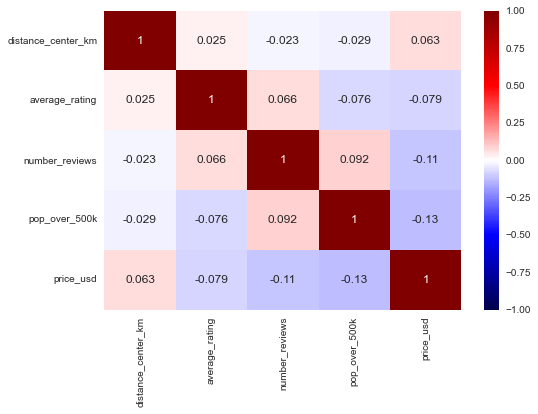

In [1151]:
sns.heatmap(df[['distance_center_km','average_rating','number_reviews','pop_over_500k','price_usd']].corr(), annot=True, cmap="seismic", vmin=-1, vmax=1)

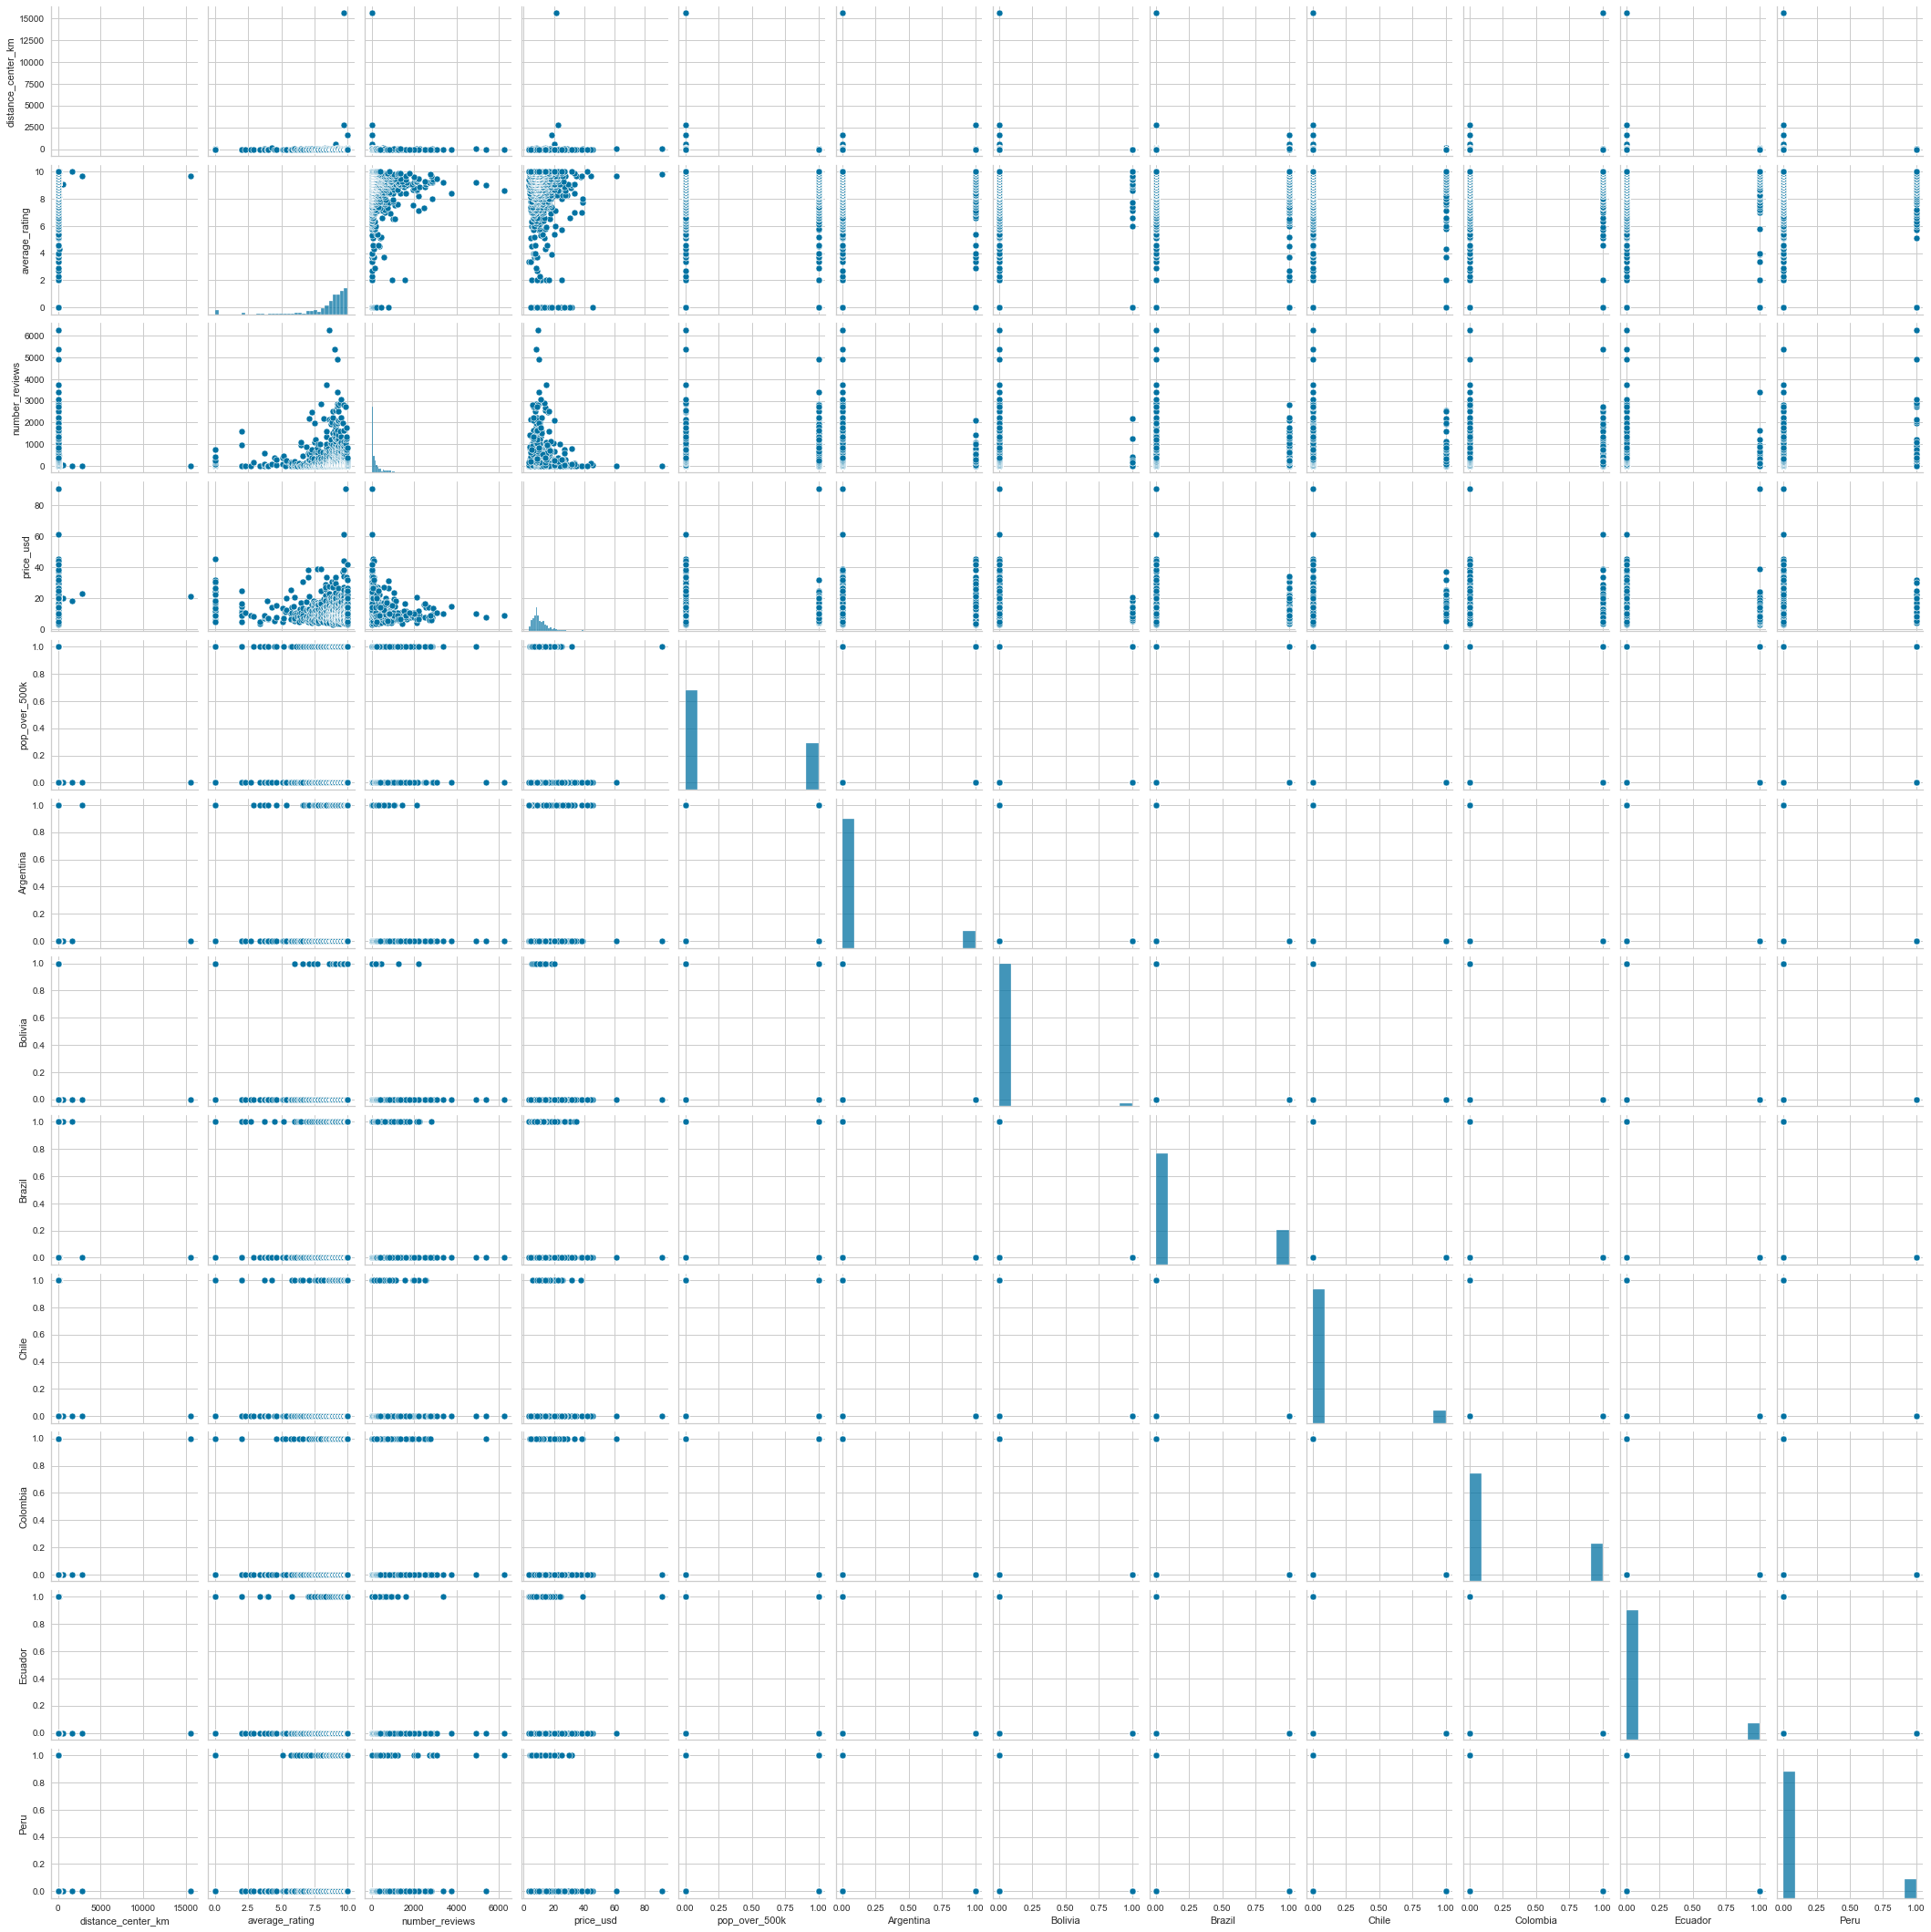

In [1152]:
sns.pairplot(df)

[Text(0.5, 1.0, 'South American Hostel Prices')]

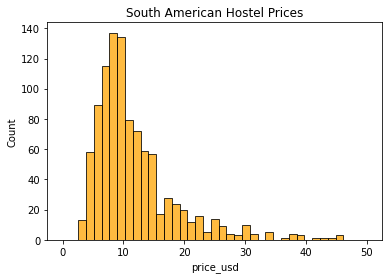

In [766]:
sns.histplot(df['price_usd'], color='orange', binrange=(0,50)).set(title='South American Hostel Prices')

[Text(0.5, 1.0, 'South American Hostel Prices')]

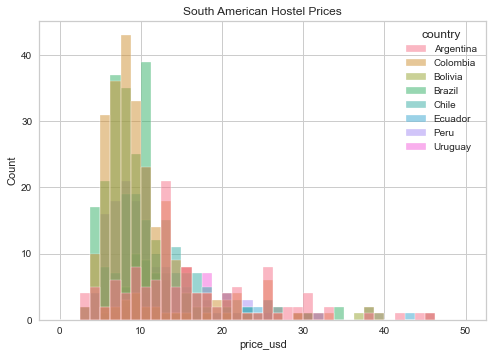

In [1129]:
sns.histplot(df, hue='country', x='price_usd', binrange=(0,50)).set(title='South American Hostel Prices')

In [1162]:
X, y = df[['distance_center_km','average_rating','number_reviews','pop_over_500k','Argentina','Bolivia','Brazil','Chile','Colombia','Ecuador','Peru']], df['price_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#simple linear regression model
lm = LinearRegression()
model_fit = lm.fit(X_train,y_train)

In [1165]:
model_fit

LinearRegression()

In [1161]:
#getting predictions
y_pred = model_fit.predict(X_test)
 
#R2
lr.score(X_train, y_train)

/Users/kate/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- Uruguay

  warnings.warn(message, FutureWarning)


ValueError: X has 11 features, but LinearRegression is expecting 12 features as input.

In [1045]:
print(f'R2 on training set: {model_fit.score(X_train, y_train):.4f}')
print(f'R2 on test set: {model_fit.score(X_test, y_test):.4f}')
print('Mean Squared Error: {}'.format(mean_squared_error(y_test, y_pred)))
print('Mean Absolute Error: {}'.format(mean_absolute_error(y_test, y_pred)))
print('Median Absolute Error: {}'.format(median_absolute_error(y_test, y_pred)))
print('Root Mean Square Error (RMSE): {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))


R2 on training set: 0.1603
R2 on test set: 0.0310
Mean Squared Error: 35.5378913222653
Mean Absolute Error: 4.2841708403584535
Median Absolute Error: 3.4130924792600696
Root Mean Square Error (RMSE): 5.961366564997098


/Users/kate/opt/anaconda3/envs/metis/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


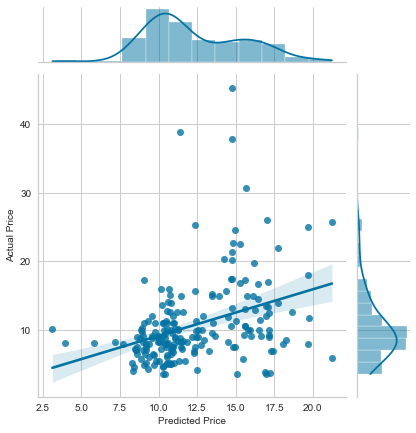

In [1046]:
#plot actual vs predicted values 
plot = sns.jointplot(y_pred, y_test, kind='reg')
plot.set_axis_labels('Predicted Price', 'Actual Price', fontsize=10)

In [876]:
#calculate variance inflation factor
def vif(df):
    vif_data = [variance_inflation_factor(df.values, i)
                for i in range(df.shape[1])]
    
    return pd.Series(vif_data, index=df.columns)

In [1050]:
#only analyze the VIF for predictors
vif(df[['distance_center_km','average_rating','number_reviews','pop_over_500k','Argentina','Bolivia','Brazil','Chile','Colombia','Ecuador','Peru','Uruguay']])

distance_center_km    1.003794
average_rating        1.073251
number_reviews        1.066515
pop_over_500k         1.031097
Argentina             1.736025
Bolivia               1.139605
Brazil                2.805210
Chile                 1.548010
Colombia              2.804198
Ecuador               1.644896
Peru                  1.886967
Uruguay               1.216078
dtype: float64

In [1053]:
print(f'R^2 score on training set: {model_fit.score(X_train, y_train):.4f}')
print(f'R^2 score on test set: {model_fit.score(X_test, y_test):.4f}')
print('Mean Absolute Error: {}'.format(mean_absolute_error(y_test, y_pred)))
print('Mean Squared Error: {}'.format(mean_squared_error(y_test, y_pred)))
print('Root Mean Square Error (RMSE): {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

R^2 score on training set: 0.1603
R^2 score on test set: 0.0310
Mean Absolute Error: 4.2841708403584535
Mean Squared Error: 35.5378913222653
Root Mean Square Error (RMSE): 5.961366564997098


In [1154]:
#creating a train\validation\test set (80/20/20)
# X, X_test, y, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=41)

In [910]:
# #model: simple Linear Model
# lm = LinearRegression()
# lm.fit(X_train,y_train)
# print("R^2 of Train Set:", round(lm.score(X_train,y_train),4))
# print("R^2 of Validation Set:", round(lm.score(X_val,y_val),4))
# print("R^2 of Test Set:", round(lm.score(X_test,y_test),4))

R^2 of Train Set: 0.1698
R^2 of Validation Set: 0.1568
R^2 of Test Set: 0.1166


In [1166]:
lm = LinearRegression()

cross_val_score(lm, X, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([-0.30312876,  0.22869468,  0.1408792 , -1.00430982, -0.01333877])

In [1167]:
cross_val_score(lm, X, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='neg_mean_absolute_error') # scoring metric

array([-5.12377713, -3.49549925, -3.42186284, -4.49626043, -4.69042196])

In [1057]:
#types of metrics sklearn accepts
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

In [1168]:
#feature engineering
def split_and_validate(X, y, metric='rmse'):
    """For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results.
    """
    
    # Train and validation split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # Score fit model on validation data
    if metric == "rmse":
        y_actual = y_val
        y_predicted = lr_model.predict(X_val)
        val_score = mean_squared_error(y_actual, y_predicted, squared=False)
    else:
        metric ="R²"
        val_score = lr_model.score(X_val, y_val)

    
    # Report results
    print("")
    print(f"Validation score for {metric}: {val_score:,.0f}")
    print("")
    print('Feature coefficient results:')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(f"{feature:<20}: {coef:>12,.0f}") 
        

In [1169]:
#pair plots of average rating and number of reviews potentially had upward-curved relationships with price
#square them and see validation results
X2 = X.copy()

X2['rating2'] = X2['average_rating'] ** 2
X2['review2'] = X2['number_reviews'] ** 2

split_and_validate(X2, y)


Validation score for rmse: 6

Feature coefficient results:
distance_center_km  :            0
average_rating      :           -1
number_reviews      :           -0
pop_over_500k       :           -1
Argentina           :            0
Bolivia             :           -4
Brazil              :           -5
Chile               :            1
Colombia            :           -5
Ecuador             :           -3
Peru                :           -5
rating2             :            0
review2             :            0


In [1170]:
X3 = X2.copy()

# multiplicative interaction
X3['rating*reviews'] = X3['average_rating'] * X3['number_reviews']

split_and_validate(X3, y)


Validation score for rmse: 6

Feature coefficient results:
distance_center_km  :            0
average_rating      :           -1
number_reviews      :            0
pop_over_500k       :           -1
Argentina           :            0
Bolivia             :           -4
Brazil              :           -5
Chile               :            1
Colombia            :           -5
Ecuador             :           -3
Peru                :           -5
rating2             :            0
review2             :            0
rating*reviews      :           -0


In [1171]:
#polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)

# Apply polynomial transformation to val set
X_val_poly = poly.transform(X_val)

# Fit a model using polynomial features
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly,y_train)

print("R^2 of Train Set with Poly:", round(lr_poly.score(X_train_poly,y_train),4))  
print("R^2 of Validation Set with Poly:", round(lr_poly.score(X_val_poly, y_val),4))
print("R^2 of Test Set with Poly:", round(lr_poly.score(poly.transform(X_test), y_test),4))

R^2 of Train Set with Poly: 0.2847
R^2 of Validation Set with Poly: 0.1592
R^2 of Test Set with Poly: 0.0815


In [1172]:
#scaling X
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#fitting Lasso
lasso = LassoCV()
lasso.fit(X_train_scaled,y_train)

print("Lasso R^2 of train set including all features:", lasso.score(X_train_scaled,y_train))
print("Lasso R^2 of validation set including all features:", lasso.score(X_val_scaled, y_val))

Lasso R^2 of train set including all features: 0.12673148491566133
Lasso R^2 of validation set including all features: 0.17661237740496472


In [1173]:
list(zip(lasso.coef_))

[(0.3958288194378501,),
 (-0.41467312452679644,),
 (-0.5308898555565595,),
 (-0.5944309717215411,),
 (0.6625821575937746,),
 (-0.15095520637777857,),
 (-1.2885996724278004,),
 (0.6262506320811624,),
 (-1.023711915669202,),
 (-0.17255966434341966,),
 (-0.8127267990237802,)]

Computing regularization path using the LARS ...


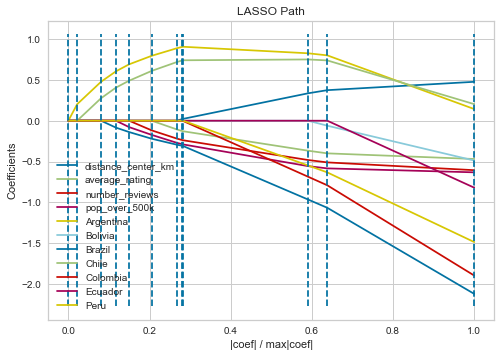

In [1174]:
from sklearn import linear_model
from sklearn.linear_model import lars_path

print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_train_scaled, y_train, 
                             method='lasso')

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle="dashed")
plt.xlabel("|coef| / max|coef|")
plt.ylabel("Coefficients")
plt.title("LASSO Path")
plt.axis("tight")
plt.legend(['distance_center_km','average_rating','number_reviews','pop_over_500k','Argentina','Bolivia','Brazil','Chile','Colombia','Ecuador','Peru'])
plt.show()

In [1175]:
#fitting Ridge
ridge = RidgeCV()
ridge.fit(X_train_scaled,y_train)

print("Ridge R^2 of training set:", ridge.score(X_train_scaled,y_train))
print("Ridge R^2 of validation set:", ridge.score(X_val_scaled, y_val))

Ridge R^2 of training set: 0.1307919762368237
Ridge R^2 of validation set: 0.186218856078314


In [1177]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [1178]:
kf = KFold(n_splits=5, shuffle=True, random_state = 42)
print(np.mean(cross_val_score(lasso, X_scaled, y, cv=kf, scoring='r2')))

0.08987001886064394


In [1179]:
kf = KFold(n_splits=5, shuffle=True, random_state = 42)
print(np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')))

0.0209700539995721


In [1180]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=1)
lm_reg.fit(X_scaled,y)
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

Ridge Regression test R^2: 0.169


In [1181]:
kf = KFold(n_splits=5, shuffle=True, random_state = 1000)

print(np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')))
print(np.mean(cross_val_score(lm_reg, X, y, cv=kf, scoring='r2')))

0.08940140245241894
0.08925591811410014


In [1182]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

#Gradient Boosting regressor
gbm = GradientBoostingRegressor(n_estimators=500, max_depth=3, learning_rate=.01)
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)

print("Gradient Boosted Regression - Test set:", r2_score(y_test, y_pred))

Gradient Boosted Regression - Test set: 0.13350550483159251


Prediction Error Plot for Gradient Boosting Regressor


/Users/kate/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


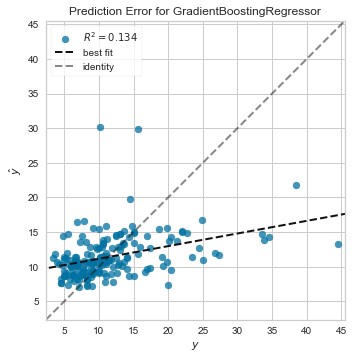

PredictionError(ax=<AxesSubplot:title={'center':'Prediction Error for GradientBoostingRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>,
                estimator=GradientBoostingRegressor(learning_rate=0.01,
                                                    n_estimators=500))


In [1183]:
#prediction Error Plot
print("Prediction Error Plot for Gradient Boosting Regressor")
print(prediction_error(gbm, X_train, y_train, X_test, y_test))

In [779]:
lr = LinearRegression()
lr.fit(X_train, y_train)

#R2
lr.score(X_train, y_train)

0.16026050465008057

In [746]:
#mean squared error
preds = lr.predict(X)
rmse = mean_squared_error(y, preds, squared=False)
rmse

6.900531879745572

In [747]:
# extract feature coefficients and intercept from fit model
print(lr.intercept_)
print(lr.coef_)

# y(pred) = f(x) = 9.48 + .42x1 -.25x2 - .001x3

17.23467730718629
[ 8.30093201e-04 -4.74645477e-01 -1.08589652e-03 -1.32743927e+00
  3.21501785e+00  4.33070556e-01 -2.76025602e+00  2.39055977e+00
 -1.99907582e+00 -1.06309725e+00 -2.24223959e+00  2.02602050e+00]


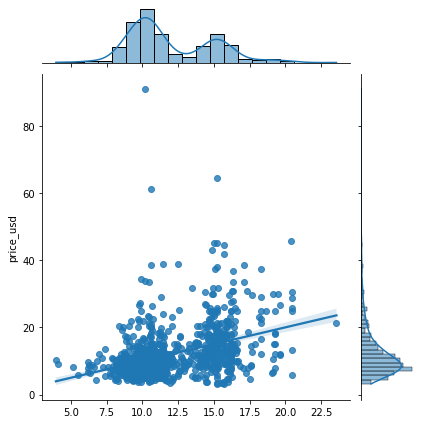

In [748]:
# generate predictions (on training data) using fit model
sns.jointplot(x=preds,y=y, kind='reg');

In [749]:
#Sum of Squared Errors
def SSE(actuals, preds):
    "Sum of squared errors"
    return np.sum((actuals - preds)**2)

SSE(y,preds)

47664.95756360835

In [750]:
rmse = mean_squared_error(y, preds, squared=False)
rmse

6.900531879745572

In [1023]:
mae = mean_absolute_error(y, preds)
mae

4.3905067850426445

In [1190]:
model = sm.OLS(y, sm.add_constant(X)) 

#Fit
fit = model.fit()

#Print out summary
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_usd   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     12.96
Date:                Fri, 28 Jan 2022   Prob (F-statistic):           4.16e-23
Time:                        00:12:50   Log-Likelihood:                -2997.5
No. Observations:                 919   AIC:                             6019.
Df Residuals:                     907   BIC:                             6077.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 17.3613      1.349     12.872      0.000      14.714      20.008
distance_center_km     0.0008      0.000      2.077      0.038    4.56e-05       0.002
average_rating        -0.2035      0.106     -1.926      0.054      -0.411       0.004
number_reviews        -0.0010      0.000     -2.901      0.004      -0.002      -0.000
pop_over_500k         -1.4848      0.458     -3.244      0.001      -2.383      -0.586
Argentina              0.7133      1.217      0.586      0.558      -1.676       3.102
Bolivia               -3.9583      1.773     -2.233      0.026      -7.438      -0.479
Brazil                -5.0841      1.135     -4.479      0.000      -7.312      -2.857
Chile                 -0.2377      1.272     -0.187      0.852      -2.734       2.259
Colombia              -4.8127      1.130     -4.259      0.000      -7.030      -2.595
Ecuador               -3.4270      1.223     -2.802      0.005      -5.827      -1.027
Peru                  -4.5867      1.199     -3.827      0.000      -6.939      -2.235
==============================================================================
Omnibus:                      845.119   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            49839.820
Skew:                           3.966   Prob(JB):                         0.00
Kurtosis:                      38.195   Cond. No.                     9.96e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.96e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1194]:
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("Linear Regression:", r2_score(y_test, y_pred), mean_absolute_error(y_test, y_pred))

lasso = Lasso(alpha = 0.006579332246575682).fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
print("Lasso Regression:", r2_score(y_test, y_pred_lasso),mean_absolute_error(y_test, y_pred_lasso))

ridge = Ridge(alpha = 0.007564633275546291).fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
print("Ridge Regression:", r2_score(y_test, y_pred_ridge),mean_absolute_error(y_test, y_pred_ridge))


Linear Regression: 0.13872693411307258 4.185355718050714
Lasso Regression: 0.1365030951119811 4.188456666849007
Ridge Regression: 0.13871284419526153 4.185404589697174


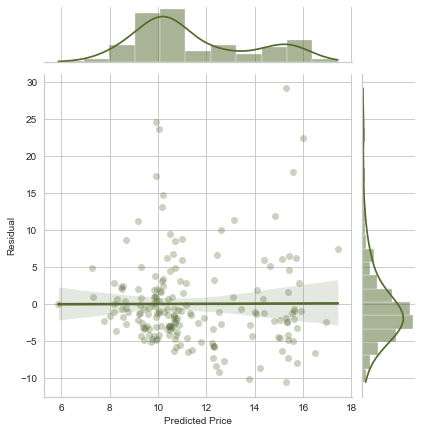

In [1198]:
#plot the ridge residuals for project appendix
ridge_residuals = y_test - y_pred_ridge
plot=sns.jointplot(x=y_pred_ridge,y=ridge_residuals, kind='reg',joint_kws = {'scatter_kws':dict(alpha=0.3)}, color='darkolivegreen')
plot.set_axis_labels('Predicted Price', 'Residual', fontsize=10)

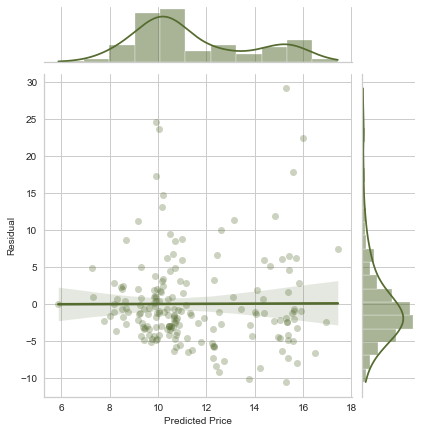

In [1200]:
#plot the lr residuals for project appendix
lr_residuals = y_test - y_pred
plot=sns.jointplot(x=y_pred,y=lr_residuals, kind='reg',joint_kws = {'scatter_kws':dict(alpha=0.3)}, color='darkolivegreen')
plot.set_axis_labels('Predicted Price', 'Residual', fontsize=10)

/Users/kate/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


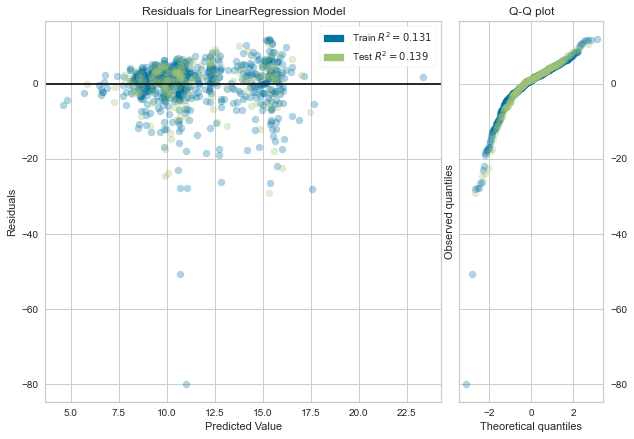


Residuals Plot


/Users/kate/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


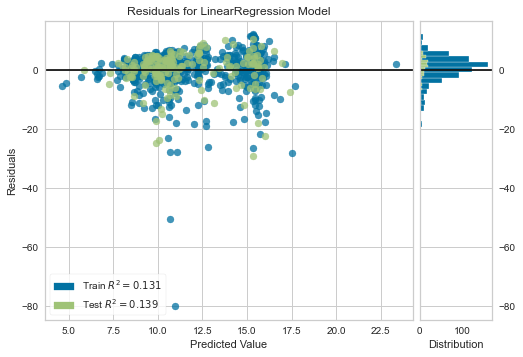

AttributeError: 'LinearRegression' object has no attribute 'line_color'

In [1191]:
# Making the Residuals Plot
plt.figure(figsize=(10,7))
res_plt = ResidualsPlot(model_fit, hist=False, qqplot=True, train_alpha=0.3, test_alpha=0.3)
res_plt.fit(X_train, y_train)  #fitting training data to the visualizer
res_plt.score(X_test, y_test)  #evaluating the model on the test data
res_plt.show();

print("\nResiduals Plot")
print(residuals_plot(model_fit, X_train, y_train, X_test, y_test))